In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import scipy
rkey = jax.random.PRNGKey(13)
from ssmjax import algs
from ssmjax.types import StateSpaceModel, LinearizationParameters, MVNormal

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
rkey, subkey = jax.random.split(rkey)

In [3]:
%matplotlib widget
def fun2d(x):
    return (x[:, None]*x).sum(axis=1)

def fun(x, *args, **kwargs):
    return 0.01*x**3

def h(x, *args, **kwargs):
    return x

Q = np.diag([1e-1])
R = np.diag([1e-1])

x = np.array([3.])
P = np.array([[4.]])

y = np.array([1.5]) 

ukf_params = dict(alpha = np.sqrt(3), kappa=0, Q=Q)

ssm = StateSpaceModel(fun, h, Q, R)

nx = 1
alpha = jnp.sqrt(3/nx)
kappa = nx*(3/2-alpha**2)/alpha**2
ut2 = dict(alpha=alpha, kappa=kappa, beta=2)
ut = LinearizationParameters(ut2, ut2)
theta = MVNormal(jnp.array([5.]), None)

ekf = algs.stateestimation.ekf(ssm)
eks = algs.stateestimation.eks(ssm)

In [6]:
%pdb on
def iterpr(initial_state, Q, R, m):
    prior = []
    updated = []
    smoothed = []
    pred, _ = m.forward_filter.propagate(initial_state, Q, linearization_point=None, theta=theta)
    prior.append(pred)
    (_, (upd, _)), _ = m.forward_filter.update(pred, y, R, linearization_point=None, theta=theta)
    updated.append(upd)
    smth, _ = m.smooth(initial_state, upd, Q, linearization_point=None, theta=theta)
    smoothed.append(smth)

    for i in range(1):
        pred, _ = m.forward_filter.propagate(initial_state, Q, linearization_point=smoothed[-1], theta=theta)
        prior.append(pred)
        (_, (upd, _)), _ = m.forward_filter.update(pred, y, R, linearization_point=updated[-1], theta=theta)
        updated.append(upd)
        smth, _ = m.smooth(initial_state, upd, Q, linearization_point=smoothed[-1], theta=theta)
        smoothed.append(smth)
    return prior, updated, smoothed

res = {}
prior, updated, smoothed = iterpr(MVNormal(x, cov=P), Q, R, eks)
res['ekf'] = [prior, updated, smoothed]

Automatic pdb calling has been turned ON


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


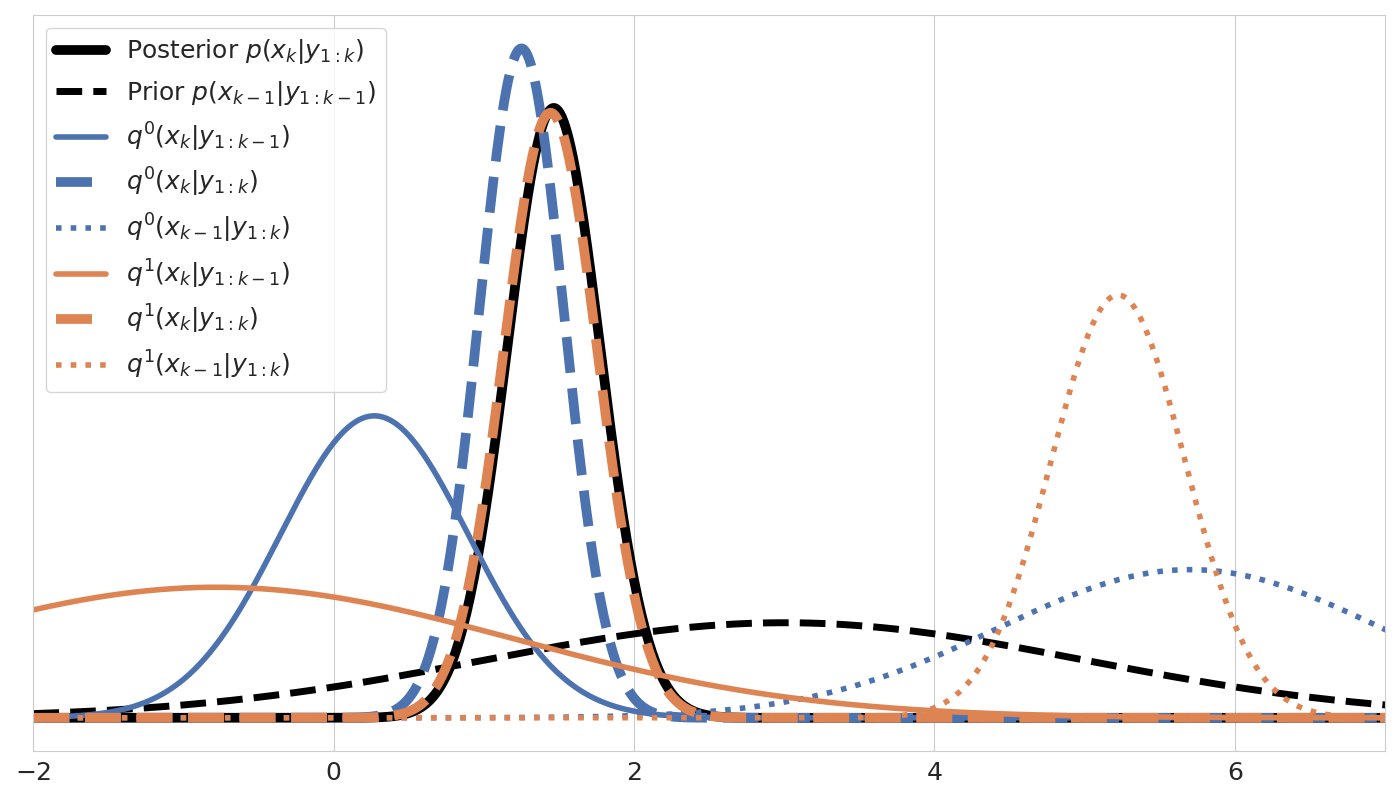

In [7]:
xst = np.linspace(-2, 10, 1000)

px = scipy.stats.norm.pdf(xst, loc=x, scale=np.sqrt(P[0]))

w = scipy.stats.norm.pdf(xst, loc=x, scale=np.sqrt(P[0]))
w /= np.sum(w)
mu = fun(xst)@w
s2 = ((fun(xst)-mu)**2)@w

a = 0.01
Psi = 3*a*P*(x**2+P)
Pyy = R + a**2*(9*x**4*P+36*x**2*P**2+15*P**3)
zh = a*(x**3+3*x*P)
xpost = zh + np.linalg.solve(Pyy+R, Pyy).T@(y-h(zh))
Ppost = Pyy - np.linalg.solve(Pyy+R, Pyy)@Pyy.T

import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('deep')

plt.close('all')
plt.rc('xtick', labelsize=18)
plt.figure(figsize=(14,8))

f = scipy.stats.norm.pdf(y, loc=h(xst), scale=np.sqrt(R[0]))

fpx = scipy.stats.norm.pdf(xst, loc=mu, scale=np.sqrt(s2))
fpx2 = scipy.stats.norm.pdf(xst, loc=zh, scale=np.sqrt(Pyy[0]))

f2 = (f*fpx2)/scipy.stats.norm.pdf(xst, loc=zh, scale=np.sqrt(Pyy[0])+np.sqrt(R[0]))
f = (f*fpx)/scipy.stats.norm.pdf(xst, loc=mu, scale=np.sqrt(s2)+np.sqrt(R[0]))

plt.plot(xst, f2.squeeze()/np.sum(f2), 'k', lw=7, label=r'Posterior $p(x_k|y_{1:k})$')
# plt.plot(xst, f/np.sum(f), 'k-', label='MCT')
plt.plot(xst, px/np.sum(px), 'k--', lw=5, label=r'Prior $p(x_{k-1}|y_{1:k-1})$')
for key, m in res.items():
    for i in range(len(m[0])):
        prior, updated, smoothed = m
        f = scipy.stats.norm.pdf(xst, loc=prior[i].mean, scale=np.sqrt(prior[i].cov[0]))
        l = plt.plot(xst, f/np.sum(f), label=r'$q^{}(x_k|y_{{1:k-1}})$'.format(i), lw=4)[0]

        f = scipy.stats.norm.pdf(xst, loc=updated[i].mean, scale=np.sqrt(updated[i].cov[0]))
        plt.plot(xst, f/np.sum(f), label=r'$q^{}(x_k|y_{{1:k}})$'.format(i), color=l.get_color(), ls='--', lw=7)

        f = scipy.stats.norm.pdf(xst, loc=smoothed[i].mean, scale=np.sqrt(smoothed[i].cov[0]))
        plt.plot(xst, f/np.sum(f), label=r'$q^{}(x_{{k-1}}|y_{{1:k}})$'.format(i), color=l.get_color(), ls=':', lw=4)

plt.yticks([])
plt.xticks(np.arange(-2, 7, 2))
plt.xlim([-2, 7])
legend = plt.legend(fontsize=18)
# legend.get_frame().set_facecolor('none')
# plt.gcf().patch.set_alpha(0.)
# plt.gca().patch.set_alpha(0.)
plt.tight_layout()
plt.savefig('dyniterillustration.eps', bbox_inches=0)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
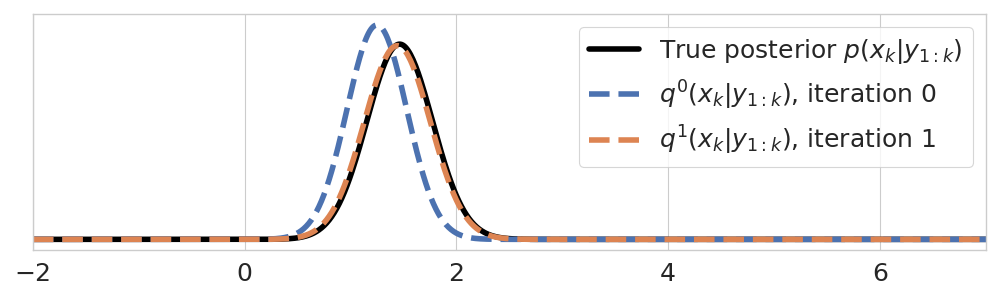

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
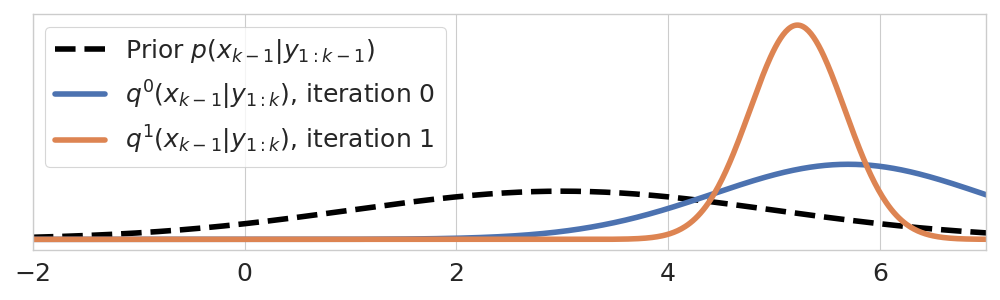

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
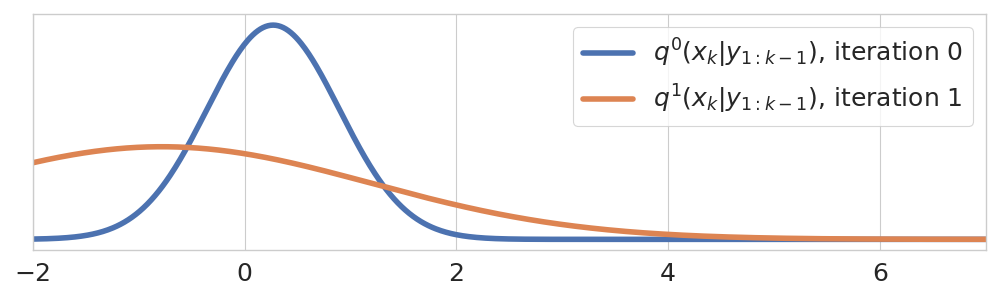

In [46]:
xst = np.linspace(-2, 10, 1000)

px = scipy.stats.norm.pdf(xst, loc=x, scale=np.sqrt(P[0]))

w = scipy.stats.norm.pdf(xst, loc=x, scale=np.sqrt(P[0]))
w /= np.sum(w)
mu = fun(xst)@w
s2 = ((fun(xst)-mu)**2)@w

a = 0.01
Psi = 3*a*P*(x**2+P)
Pyy = R + a**2*(9*x**4*P+36*x**2*P**2+15*P**3)
zh = a*(x**3+3*x*P)
xpost = zh + np.linalg.solve(Pyy+R, Pyy).T@(y-h(zh))
Ppost = Pyy - np.linalg.solve(Pyy+R, Pyy)@Pyy.T

import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('deep')

plt.close('all')
sns.set_context("paper")
plt.rc('xtick', labelsize=18)
plt.rc('axes', labelsize=20)
# plt.figure(figsize=(14,8))

figs = []
# fig, ax = plt.subplots(3, 1, figsize=(14,10))

f = scipy.stats.norm.pdf(y, loc=h(xst), scale=np.sqrt(R[0]))
fpx = scipy.stats.norm.pdf(xst, loc=mu, scale=np.sqrt(s2))
fpx2 = scipy.stats.norm.pdf(xst, loc=zh, scale=np.sqrt(Pyy[0]))

f2 = (f*fpx2)/scipy.stats.norm.pdf(xst, loc=zh, scale=np.sqrt(Pyy[0])+np.sqrt(R[0]))
f = (f*fpx)/scipy.stats.norm.pdf(xst, loc=mu, scale=np.sqrt(s2)+np.sqrt(R[0]))
axs = []

for i in range(3):
    figs.append(plt.figure(figsize=(10, 3)))
    axs.append(figs[i].subplots(1,1))
    # axs.append(figs[i].add_axes([0, 0, 1, 1]))

axs[2].plot(xst, f2.squeeze()/np.sum(f2), 'k', lw=4, label=r'True posterior $p(x_k|y_{1:k})$')
# plt.plot(xst, f/np.sum(f), 'k-', label='MCT')
axs[0].plot(xst, px/np.sum(px), 'k--', lw=4, label=r'Prior $p(x_{k-1}|y_{1:k-1})$')

m = res['ekf']
for i in range(len(m[0])):
    prior, updated, smoothed = m
    f = scipy.stats.norm.pdf(xst, loc=prior[i].mean, scale=np.sqrt(prior[i].cov[0]))
    l = axs[1].plot(xst, f/np.sum(f), label=r'$q^{}(x_k|y_{{1:k-1}})$, iteration {}'.format(i, i), lw=4)[0]

    f = scipy.stats.norm.pdf(xst, loc=updated[i].mean, scale=np.sqrt(updated[i].cov[0]))
    axs[2].plot(xst, f/np.sum(f), label=r'$q^{}(x_k|y_{{1:k}})$, iteration {}'.format(i, i), color=l.get_color(), ls='--', lw=4)

    f = scipy.stats.norm.pdf(xst, loc=smoothed[i].mean, scale=np.sqrt(smoothed[i].cov[0]))
    axs[0].plot(xst, f/np.sum(f), label=r'$q^{}(x_{{k-1}}|y_{{1:k}})$, iteration {}'.format(i, i), color=l.get_color(), lw=4)

for axi in axs:
    axi.set_yticks([])
    axi.set_xticks(np.arange(-2, 7, 2))
    axi.set_xlim([-2, 7])
    legend = axi.legend(fontsize=18)
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])

for fig in figs:
    fig.tight_layout()
# axs[0].set_title('Smoothed / Prior')
# axs[1].set_title('Time update')
# axs[2].set_title('Measurement update')

# legend.get_frame().set_facecolor('none')
# plt.gcf().patch.set_alpha(0.)
# plt.gca().patch.set_alpha(0.)
# plt.tight_layout()
figs[0].savefig('smooth-illustration.eps', bbox_inches=0)
figs[1].savefig('pred-illustration.eps', bbox_inches=0)
figs[2].savefig('post-illustration.eps', bbox_inches=0)
# plt.savefig('dyniterillustration.eps', bbox_inches=0)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


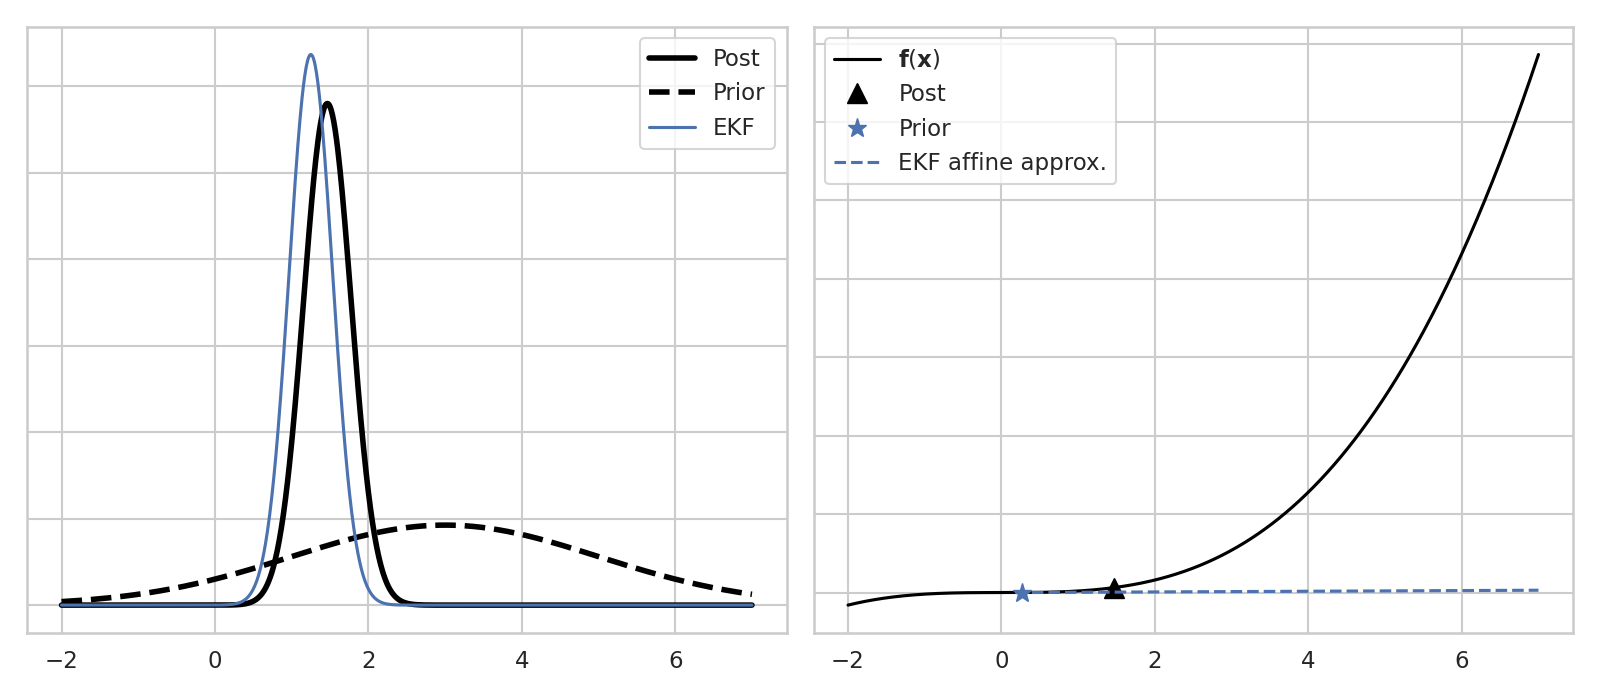

In [35]:
xst = np.linspace(-2, 7, 1000)

px = scipy.stats.norm.pdf(xst, loc=x, scale=np.sqrt(P[0]))

w = scipy.stats.norm.pdf(xst, loc=x, scale=np.sqrt(P[0]))
w /= np.sum(w)
mu = fun(xst)@w
s2 = ((fun(xst)-mu)**2)@w

a = 0.01
Psi = 3*a*P*(x**2+P)
Pyy = R + a**2*(9*x**4*P+36*x**2*P**2+15*P**3)
zh = a*(x**3+3*x*P)
xpost = zh + np.linalg.solve(Pyy+R, Pyy).T@(y-h(zh))
Ppost = Pyy - np.linalg.solve(Pyy+R, Pyy)@Pyy.T

import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('deep')

plt.close('all')
plt.rc('xtick', labelsize=18)
plt.rc('axes', labelsize=20)

f = scipy.stats.norm.pdf(y, loc=h(xst), scale=np.sqrt(R[0]))
fpx = scipy.stats.norm.pdf(xst, loc=mu, scale=np.sqrt(s2))
fpx2 = scipy.stats.norm.pdf(xst, loc=zh, scale=np.sqrt(Pyy[0]))

f2 = ((f*fpx2)/scipy.stats.norm.pdf(xst, loc=zh, scale=np.sqrt(Pyy[0])+np.sqrt(R[0]))).flatten()


def plot_dyniter(res, xst, iters):
    ind = np.argmax(f2)
    prior, updated, smoothed = res['ekf']
    fig, ax = plt.subplots(1, 2, figsize=(16, 7))
    
    ax[0].plot(xst, f2/np.sum(f2), 'k', lw=4, label='Post')
    ax[0].plot(xst, px/np.sum(px), 'k--', lw=4, label='Prior')
    
    # Function and true post and prior
    handles = []
    labels = []
    l = ax[1].plot(xst, fun(xst), 'k')[0]
    handles.append(l), labels.append(r'$\mathbf{f}(\mathbf{x})$')
    l = ax[1].plot(xst[ind], fun(xst[ind]), '^k', markersize=14)[0]
    handles.append(l), labels.append("Post")
    
    l = ax[1].plot(prior[0].mean, fun(prior[0].mean), '*', markersize=14)[0]
    handles.append(l), labels.append("Prior")
    # Prior affine approx.
    l = plot_affine_approx(prior[0], xst, ax=ax[1], color=l.get_color(), linestyle='--')
    handles.append(l), labels.append("EKF affine approx.")
    
    f = scipy.stats.norm.pdf(xst, loc=updated[0].mean, scale=np.sqrt(updated[0].cov[0]))
    ax[0].plot(xst, f/np.sum(f), label='EKF')
    
    for i in range(iters):
        f = scipy.stats.norm.pdf(xst, loc=updated[i+1].mean, scale=np.sqrt(updated[i+1].cov[0]))
        l = ax[0].plot(xst, f/np.sum(f), label='DIEKF iter={}'.format(i+1))[0]
        point = ax[1].plot(updated[i+1].mean, fun(updated[i+1].mean), '*', markersize=14, color=l.get_color())[0]
        aff = plot_affine_approx(updated[i+1], xst, ax=ax[1], color=l.get_color(), linestyle='--')
        handles.append((point, aff)), labels.append("DIEKF iter={}, affine approx.".format(i+1))
        

    ax[0].set_yticklabels([])
    ax[1].set_yticklabels([])
    ax[0].legend()
    ax[1].legend(handles, labels)
    plt.tight_layout()
    plt.savefig('dyniterfilter_iter={}.eps'.format(iters), bbox_inches=0)
    plt.show()

with sns.plotting_context("talk"):
    plot_dyniter(res, xst, 0)


In [22]:
from ssmjax.transforms.linearization import first_taylor
def plot_affine_approx(x, xs, ax, **kwargs):
    affine_model = first_taylor(fun, state_distribution=x, parameter_distribution=MVNormal(jnp.array([0.]), None))
    y = affine_model.state_jac.flatten()*xs + affine_model.offset.flatten()
    l = ax.plot(xs[y>0], y[y>0], **kwargs)[0]
    return l

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


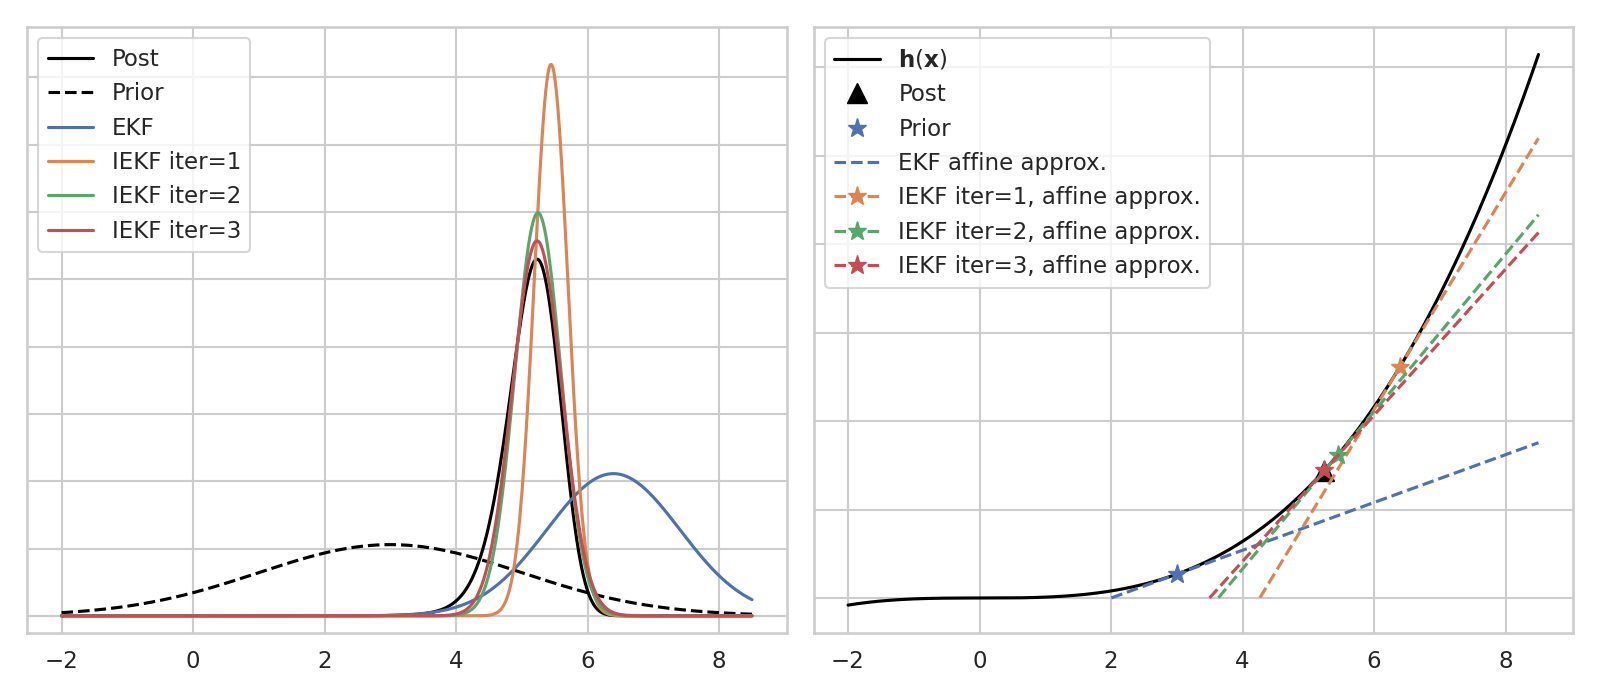

In [30]:
x = np.array([3.])
P = np.array([[4.]])
R = np.diag([1e-1])

a = 0.01
def fun(x, *args, **kwargs):
    return a*x**3

y = np.array([1.5])
xs = np.linspace(-2, 8.5, 1000)

prior = MVNormal(x, cov=P)
posts = []
m = algs.stateestimation.ekf(model=StateSpaceModel(transition_function=fun, observation_function=fun, transition_covariance=Q, observation_covariance=R))
theta = jnp.array([0.])
(_, (post, _)), _ = m.update(prior, y, R, linearization_point=prior, theta=theta)
posts.append(post)
for i in range(5):
    (_, (post, _)), _ = m.update(prior, y, R, linearization_point=posts[-1], theta=theta)
    posts.append(post)

def plot_stage(posts, prior, xs, iters):
    x, P = prior.mean, prior.cov

    Psi = 3*a*P*(x**2+P)
    Pyy = 1e-1 + a**2*(9*x**4*P+36*x**2*P**2+15*P**3)
    zh = a*(x**3+3*x*P)
    xt = x + np.linalg.solve(Pyy, Psi).T*(y-zh)
    Pt = P - np.linalg.solve(Pyy, Psi).T*Psi

    z = scipy.stats.norm.pdf(y, loc=fun(xs), scale=np.sqrt(1e-1))
    px = scipy.stats.multivariate_normal.pdf(xs, mean=x, cov=P)
    f = ((z*px)/scipy.stats.norm.pdf(y, loc=zh, scale=np.sqrt(Pyy))).squeeze()

    ind = np.argmax(f)
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 7))
    
    handles = []
    labels = []
    # Function and true post and prior
    l = ax[1].plot(xs, fun(xs), 'k')[0]
    handles.append(l), labels.append(r'$\mathbf{h}(\mathbf{x})$')
    l = ax[1].plot(xs[ind], fun(xs[ind]), '^k', markersize=14)[0]
    handles.append(l), labels.append("Post")
    l = ax[1].plot(prior.mean, fun(prior.mean), '*', markersize=14)[0]
    handles.append(l), labels.append("Prior")
    # Prior affine approx.
    l = plot_affine_approx(prior, xs, ax=ax[1], color=l.get_color(), linestyle='--')
    handles.append(l), labels.append("EKF affine approx.")
    
    # True post and prior
    fekf = scipy.stats.multivariate_normal.pdf(xs, mean=posts[0].mean, cov=posts[0].cov)
    ax[0].plot(xs, f/np.sum(f), 'k-', label='Post')
    ax[0].plot(xs, px/np.sum(px), 'k--', label='Prior')
    ax[0].plot(xs, fekf/np.sum(fekf), label='EKF')
    
    for i in range(iters):
        fiekf = scipy.stats.multivariate_normal.pdf(xs, mean=posts[i+1].mean, cov=posts[i+1].cov)
        l = ax[0].plot(xs, fiekf/np.sum(fiekf), label='IEKF iter={}'.format(i+1))[0]
        point = ax[1].plot(posts[i].mean, fun(posts[i].mean), '*', markersize=14, color=l.get_color())[0]
        aff = plot_affine_approx(posts[i], xs, ax=ax[1], color=l.get_color(), linestyle='--')
        handles.append((point, aff)), labels.append("IEKF iter={}, affine approx.".format(i+1))
        
    ax[1].legend(handles, labels, loc='upper left')
    ax[0].legend(loc='upper left')
    ax[0].set_ylim([-0.0005, 0.0175])
    ax[0].set_yticklabels([])
    ax[1].set_yticklabels([])
    plt.tight_layout()
    plt.savefig('iterfilter_iter={}.eps'.format(iters), bbox_inches=0)
    plt.show()

with sns.plotting_context("talk"):
    plot_stage(posts, prior, xs, 3)

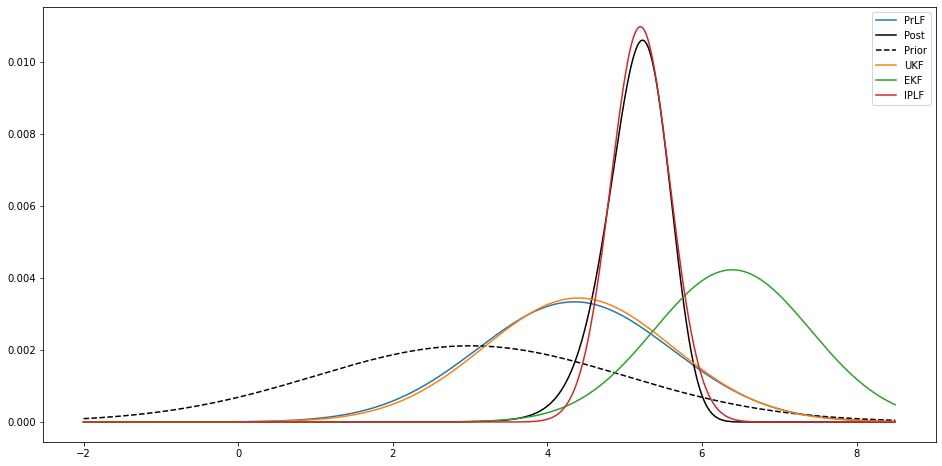

In [5]:
x = np.array([3.])
P = np.array([[4.]])
R = np.diag([1e-1])

a = 0.01
def fun(x):
    return a*x**3

y = np.array([1.5])

params = dict(transition_function=fun, measurement_function=fun, Q=Q, R=R, jit=False)
ukf_params = params | dict(alpha = np.sqrt(3), kappa=0, Q=Q)
mukf = ukf.UnscentedKalmanFilter(ukf_params)
mekf = ekf.ExtendedKalmanFilter(params)
miplf = iplf.IteratedUnscentedPosteriorLinearizationFilter(ukf_params | dict(gamma=1e-20))

xu, Pu = mukf.update(y, x, P)
xe, Pe = mekf.update(y, x, P)
xi, Pi = miplf.update(y, x, P)

Psi = 3*a*P*(x**2+P)
Pyy = 1e-1 + a**2*(9*x**4*P+36*x**2*P**2+15*P**3)
zh = a*(x**3+3*x*P)
xt = x + np.linalg.solve(Pyy, Psi).T*(y-zh)
Pt = P - np.linalg.solve(Pyy, Psi).T*Psi

xs = np.linspace(-2, 8.5, 1000)

z = scipy.stats.norm.pdf(y, loc=fun(xs), scale=np.sqrt(1e-1))
px = scipy.stats.multivariate_normal.pdf(xs, mean=x, cov=P)
f = ((z*px)/scipy.stats.norm.pdf(y, loc=zh, scale=np.sqrt(Pyy))).squeeze()

fprlf = scipy.stats.multivariate_normal.pdf(xs, mean=xt, cov=Pt)
fukf = scipy.stats.multivariate_normal.pdf(xs, mean=xu, cov=Pu)
fekf = scipy.stats.multivariate_normal.pdf(xs, mean=xe, cov=Pe)
fiplf = scipy.stats.multivariate_normal.pdf(xs, mean=xi, cov=Pi)

plt.figure(figsize=(16,8))
plt.plot(xs, fprlf/np.sum(fprlf), label='PrLF')
plt.plot(xs, f/np.sum(f), 'k-', label='Post')
plt.plot(xs, px/np.sum(px), 'k--', label='Prior')
plt.plot(xs, fukf/np.sum(fukf), label='UKF')
plt.plot(xs, fekf/np.sum(fekf), label='EKF')
l = plt.plot(xs, fiplf/np.sum(fiplf), label='IPLF')[0]

# for i in range(len(xii)):
#     fiplf = scipy.stats.multivariate_normal.pdf(xs, mean=xii[i], cov=Pii[i])
#     plt.plot(xs, fiplf/np.sum(fiplf), label='IPLF {}'.format(i))

plt.legend()
plt.show()

In [ ]:
xs = np.linspace(-.5, 1, 50)
ys = fun(xs)
ythat = At.squeeze()*xs+bt
yuthat = Au.squeeze()*xs+bu

X, W = linearizations.ut_sigma_points(mu, Sigma, params)

fig = plt.figure(figsize=(16, 8))
plt.plot(xs, ys, 'k')
plt.plot(xs, ythat, '--', label='Taylor')
plt.plot(xs, yuthat, '-.', label='Unscented')
plt.fill_between(xs, yuthat+2*np.sqrt(Omegau.squeeze()), yuthat-2*np.sqrt(Omegau.squeeze()), color='tab:orange', ls='-.', alpha=.3)#, '-.', label='Unscented 2sigma')
plt.plot(X, fun(X), '^g', label='Sigma Points')
plt.plot(mu, fun(mu), 'r*')
plt.legend()
plt.show()

In [ ]:
X1, X2 = np.meshgrid(np.linspace(-.5, .5, 50), np.linspace(-.5, .5, 50))
X = np.array([X1.T.flatten(), X2.T.flatten()])
Y = fun2d(X)

Ythat = At@X+bt[:,None]
Yuthat = Au@X+bu[:,None]

fig = plt.figure(figsize=(20, 16))
ax = plt.axes(projection='3d')
ax.plot_surface(X1, X2, Y[0,:].reshape(50, 50), alpha=.5)
ax.plot_surface(X1, X2, Ythat[0,:].reshape(50, 50), alpha=.3)
ax.plot_surface(X1, X2, Yuthat[0,:].reshape(50, 50), alpha=.3)
plt.show()

In [ ]:
g = jax.vmap(jnp.matmul, (1, 0), 2)
ze = np.arange(10).reshape(2, -1)
xe = np.arange(10).reshape(2,-1)[:, :, None]
# g(xe, ze.T)
# ze[:, :, None]@ze.T[:, None, :]
ze[None, :, :].shape
ze[:, None, :].shape
(ze[:, None, :]*ze[None, :, :])[:, :, 1]

ze[:,[1]]@ze[:,[1]].T

In [ ]:
from scipy import stats
stats.multivariate_normal(mean=[2], cov=[2]).mean